# MATH3349 / 4349 Special Topics: Computational Optimal Transport

## Optimal Transport with the Network Simplex Method

$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This project we solve the discrete optimal transport problem 
problem with the network simplex update method. Although this will be a slower method than the linear programming approach, it will be instructive to consider.

In [1]:
import numpy as np
import scipy.optimize
import scipy.sparse
import matplotlib.pyplot as plt

Consider two dicrete distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^2$.

First we set the number of points $(n,m)$ in the two clouds

In [2]:
n = 6
m = 8

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$. In this example we'll have two rows of points sitting opposite each other in lines. This example will _look_ a lot like a the bipartite graphs that we see in the literature. Note that this is just for convenience of visualising the algorithm! The algorithm works for just about any pair of discrete probability measures.

In [3]:
np.random.seed(2) # We set the random seed to get the same results each time we run this

X = np.vstack((-0.25 * np.ones(n), np.linspace(1, -1, n)))
Y = np.vstack((0.25 * np.ones(m), np.linspace(1, -1, m)))

Generate the weights $a,b$. Note that we're going to generate three sub-sets of weights to ensure we get three separate trees in our NW corner rule forest.

In [4]:
normalize = lambda a: a/np.sum(a)

num_sub_normalized = 3

np.random.seed(0)
a_thirds = np.sort(np.random.choice(np.arange(n), size=num_sub_normalized-1, replace=False))
a_thirds = np.insert(a_thirds, [0,num_sub_normalized-1], [0,n])

b_thirds = np.sort(np.random.choice(np.arange(m), size=num_sub_normalized-1, replace=False))
b_thirds = np.insert(b_thirds, [0,num_sub_normalized-1], [0,m])

print(a_thirds)
print(b_thirds)

a = np.zeros((n, 1))
b = np.zeros((m, 1))

sub_weights = normalize(np.random.rand(num_sub_normalized))

for i in range(num_sub_normalized):
    num_sub = a_thirds[i+1] - a_thirds[i]
    a[a_thirds[i]:a_thirds[i+1],:] = sub_weights[i] * normalize(np.random.rand(num_sub, 1))

    num_sub = b_thirds[i+1] - b_thirds[i]
    b[b_thirds[i]:b_thirds[i+1],:] = sub_weights[i] * normalize(np.random.rand(num_sub, 1))
    

[0 2 5 6]
[0 1 6 8]


Helper function for display of point cloud measures.

In [5]:
# Nice colours
c1 = '#2ca02c' # Forest green
c2 = '#ff7f0e' # Burnt orange

def myplot(x,y,weight,col,alpha=None): 
    plt.scatter(x,y, s=weight*20, edgecolors="k", c=col, linewidths=1, alpha=alpha, zorder=1)

Display the point clouds.
The size of each dot is proportional to its probability density weight.

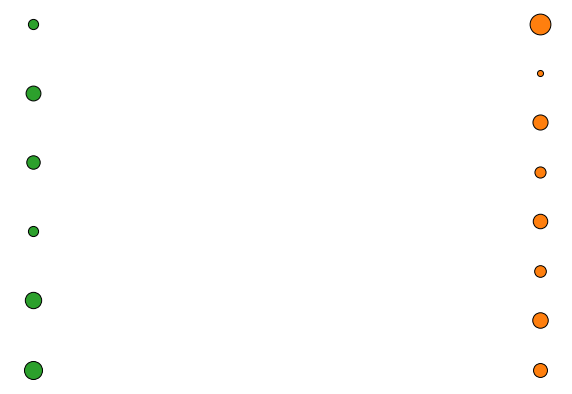

In [6]:
plt.figure(figsize = (10,7))
plt.axis("off")

for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, c1)
    
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, c2)
    
plt.show()

We compute the cost matrix $C_{i,j} := \norm{x_i-y_j}^p$ for whatever $p$ we want, but we will use $p=2$ by default.

In [7]:
def distance_matrix(x, y, p=2):
    return np.linalg.norm(x.T[:,np.newaxis] - y.T, axis=-1)**p

C = distance_matrix(X,Y)

# Task 1: Implementing the NW Corner rule to make an extremal coupling P

Follow the steps in section 3.4.2 of Peyré and Cuturi to find an extremal coupling.

It would be helpful if you work through the indices ```i``` and ```j``` in increasing order (unlike in the video where I worked through the ```j``` index in reverse), for the sake of marking.

In [8]:
tol = 1e-14

P = np.zeros((n, m))

#
#
# FILL IN CODE HERE TO COMPUTE AN EXTREMAL COUPLING P
#
#

### Plot the coupling

We can plot the coupling graphically using lines with thickness proportional to the amount of mass transfer, and do a simple greyscale density plot as well.

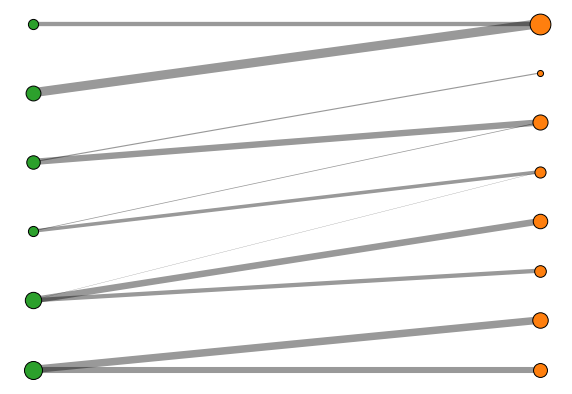

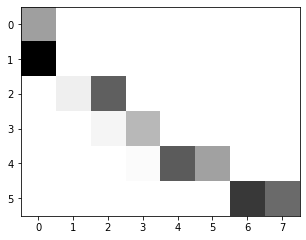

In [9]:
I, J = np.nonzero(P > tol)

plt.figure(figsize = (10,7))
plt.axis('off')

for i in range(len(a)):
    myplot(X[0,i], X[1,i], a[i]*len(a)*10, c1)
for j in range(len(b)):
    myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, c2)
    
# Plot the lines between the points when there is a nonzero amount in the coupling between points
# Note that in this plot, the lines are proportional to the amount of mass coupled from a to b.
for k in range(len(I)):
    h = plt.plot(np.hstack((X[0,I[k]],Y[0,J[k]])),np.hstack(([X[1,I[k]], Y[1,J[k]]])),'k', lw = 50*P[I[k], J[k]], alpha=0.4, zorder=0)
plt.show()

plt.figure(figsize = (5,5))
plt.imshow(P, cmap='Greys')
plt.show()

# Testing the extremal plan.

One helpful result is Proposition 3.4, which states that an extremal coupling has no cycles.

So, although it's not _technically_ the case that a coupling ```P``` with no cycles is an extremal coupling, in most cases it's true. In any case, we're going to want to detect cycles later, so lets make a routine to test a graph for cycles.

We do this through the graph adjacency matrix for ```P```, which we can easily generate by just writing

``` G_adj = (P > tol)```

This adjacency matrix takes values of either ```True``` or ```False```. The value ```G_adj[i, j]``` is ```True``` if there is some mas transfered from ```i``` to ```j```, i.e. that ```P[i,j] > 0```. Here however, we use our tolerance parameter ```tol```, as we may have values of ```P``` that are very close to 0. 

In [10]:
G_adj = (P > tol)

# Task 2: Detect if ```P``` contains any cycles

In the box below, fill out the details in ```detect_cycles(G_loc)```. We will use the convention that any variable used inside a function call has the ```_loc``` suffix (otherwise we can get namespace clashes in Jupyter). The only global variables we'll refer to are ```n```, ```m```, and ```C```.

The method ```detect_cycles``` should return a list of pairs that are 

$$ \large
(i_1, j_1^\prime), (j_1^\prime, i_2), (i_2, j_2^\prime), \ldots, (i_\ell, j_\ell^\prime), (j_\ell^\prime, i_1)
$$

so if ```cycle = detect_cycles(G_adj)``` returns a cycle, then ```cycle[0] = [i_1, j_1]```

My suggestion is to implement this with a __recursive function__. That is, a function that calls itself. As our graph is quite small, we know the depth of recursion is not going to be too much. This is probably the easiest way to implement the method, although you are free to do it how you please.

Something you can do (but don't have to) is something like the following pseudo-code:

```
step_forward(vertex, path_so_far):
    
    if vertex is in path_so_far:
        # In this case we have found a cycle!
    
        return path_so_far
        
    else:
        # We haven't found a cycle, so lets test every possible direction from here
    
        append vertex to path_so_far
    
        if there are other vertices connected to vertex:
            
            for each next_vertex connected to vertex:
                # Note that you need to make sure that next_vertex
                # is _not_ the previous vertex in the path....
    
                step_forward(next_vertex, path_so_far)
                
        else:
            # In this case we've come to the end of a possible path without finding a cycle
            # as the current vertex has no further connections.
            
            return None
```



In [19]:

    
def detect_cycle(G_loc):

    #
    #
    # FILL IN CODE HERE TO FIND A CYCLE IN G_loc
    # If there is a cycle, return the cycle as a list of pairs
    # If there is no cycle, return None
    #
    #
    
    pass
    
    

### Now use this routine you coded to 

Check that the graph given by non-zero entries in ```P``` has no cycles using the routine you just wrote, and that the number of non-zero entries in ```P``` is $n+m-1$.

In [12]:
print(f'Number of non-zero: {len(P[P>tol])} (n + m-1 = {n + m-1}).\n')

if detect_cycle(G_adj):
    print('Error: cycle detected in the coupling P')
else:
    print('No cycle detected in the coupling P')

Number of non-zero: 11 (n + m-1 = 13).

No cycle detected in the coupling P


# Task 3: Obtaining a dual pair complimentary on the graph ```G_adj```

Now follow the steps in Section 3.5.1 to build two functions (or rather, vectors) $f$ and $g$ that are complimentary to $P$ in the sense that

$$
f_i + g_j = C_{i, j}
$$

for any $i$ and $j$ where the vertices ```i``` and ```j``` are adjacent according to ```G_adj``` (which mostly is the case when```P[i,j] > 0```). To do this we have to step through the vertices as described on page 46 of Peyré and Cuturi.

You should write your code in the function ```find_comp_pair(G_loc)```.

My suggestion again is to implement this with a __recursive function__.

If you make a recursive function, I would suggest having a function ```propogate_dual_soln``` that is called for a vertex, performs the calculation for ```f``` or ```g```, and then calls itself for each of the vertices the current one is connected to. This would end up similar to the way the ```step_forward``` function in the cycle detection algorithm would work.

In [20]:

def find_comp_pair(G_loc):
    
    #
    #
    # FILL IN THIS ROUTINE
    #
    #
    
    pass

Now use the function ```find_comp_pair``` to find the complimentary pair ```f``` and ```g``` according the graph given by ```G_adj```.

In [ ]:
f, g = find_comp_pair(G_adj)

# Find the flaw in our dual pair

We have now generated two vectors $f \in \RR^n$ and $g \in \RR^m$ that are _complimentary_ to $P$ in the sense that $f_i + g_j = C_{i,j}$ _*if we know that $P_{i,j} > 0$*_.

But there could be some pair $i, j$ for which $f_i + g_j > C_{i,j}$ when $P_{i,j} = 0$. Lets search the forest to find such a pair. This code is provided for you.

You will use the routine ```find_nonfeas_edges``` in the later steps to improve the coupling with the network simplex method. First we create a handy plotting routine ```plot_and_diagnose``` to be able to display the results of the algorithm (which you can use for debugging in later steps)

In [15]:
def plot_and_diagnose(f_loc, g_loc, P_loc, G_loc):

    # Now we do a plot to see which ones aren't complimentary
    plt.figure(figsize = (10,7))
    plt.axis('off')

    plt.text(X[0,0]-0.04, X[1,0] + 0.2, r'$f_i$', fontsize=14, horizontalalignment='center', verticalalignment='center')
    plt.text(Y[0,0]+0.04, Y[1,0] + 0.2, r'$g_j$', fontsize=14,  horizontalalignment='center', verticalalignment='center')
    for i in range(len(a)):
        myplot(X[0,i], X[1,i], a[i]*len(a)*10, c1)
        plt.text(X[0,i]-0.04, X[1,i], f'{f_loc[i]:.3f}', horizontalalignment='center', verticalalignment='center')

    for j in range(len(b)):
        myplot(Y[0,j], Y[1,j], b[j]*len(b)*10, c2)
        plt.text(Y[0,j]+0.04, Y[1,j],  f'{g_loc[j]:.3f}', horizontalalignment='center', verticalalignment='center')

    G_I, G_J = np.nonzero(G_loc)
    for (i, j) in zip(G_I, G_J):
        if P_loc[i,j] > tol:
            plt.plot(np.hstack((X[0,i],Y[0,j])),np.hstack(([X[1,i], Y[1,j]])),'k', lw = 50*P_loc[i, j], alpha=0.4, zorder=0)
        else:
            # Then there is a connection made by the graph in the Newtork Simplex method...
            plt.plot(np.hstack((X[0,i],Y[0,j])),np.hstack(([X[1,i], Y[1,j]])),'b', lw = 2, alpha=0.4, zorder=0)            

    nonfeas_edges_loc = find_nonfeas_edges(f_loc, g_loc, C)
    
    offset = -np.ones(m)
    for i,j in nonfeas_edges_loc:
        # How many edges to the same point j are there (for text-offset purposes)
        offset[j] += 1

        plt.plot(np.hstack((X[0,i],Y[0,j])),np.hstack(([X[1,i], Y[1,j]])),'r', lw = 1, alpha=0.4, zorder=0)
        plt.text(Y[0,j] + 0.2, Y[1,j] - offset[j]*0.08, rf'f[{i}] + g[{j}] = {f_loc[i]+g_loc[j]:.3f} > C[{i},{j}] = {C[i,j]:.3f}', c='r', fontsize=12, horizontalalignment='center', verticalalignment='center')

    plt.show()

### UPDATE 6/10/21

Part of the problem I was having getting this solution to work is that the comparison

$$ \large
f_i + g_j > C_{i,j}
$$

should in fact be

$$ \large
f_i + g_j > C_{i,j} + \epsilon
$$

to account for machine precision, where $\epsilon$ is a small tolerance, here chosen to be ```tol``` once again.

Edges [i,j] that are not complimentary: 
[[0, 1], [1, 1], [1, 2], [3, 6], [4, 6], [4, 7]]


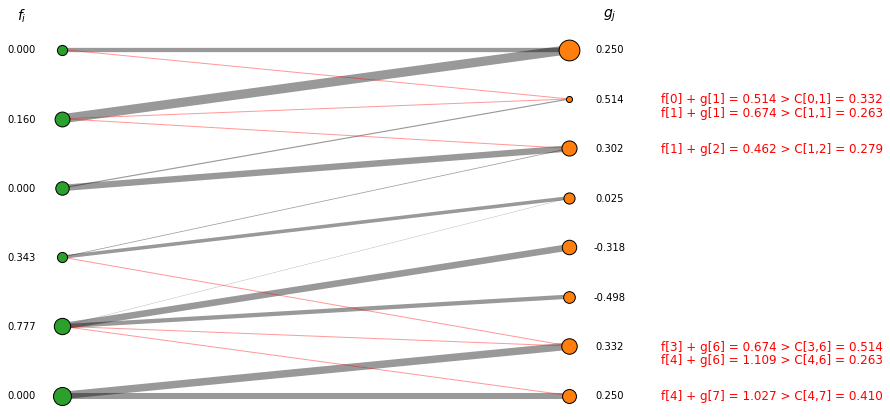

In [16]:
def find_nonfeas_edges(f, g, C):
    nonfeas_edges = []
    for i in range(n):
        for j in range(m):
            if f[i] + g[j] > C[i, j] + tol:
                nonfeas_edges = nonfeas_edges + [[i,j]]
    return nonfeas_edges

nonfeas_edges = find_nonfeas_edges(f, g, C)    
print(f'Edges [i,j] that are not complimentary: \n{nonfeas_edges}')

plot_and_diagnose(f, g, P, (P>tol))

# Task 4: Use the Network Simplex method to refine the pair ```f``` and ```g```

Work through the steps in section 3.5.2 of Peyré and Cuturi to refine the dual solutions ```f``` and ```g```. 

You will need to add edges to the graph. If you want to add an edge between vertex ```i``` and vertex ```j```, simply set ```G_adj[i,j] = True```.

You will need to loop until there are _no more nonfeasible edges_, so we loop until ```len(nonfeas_edges) == 0```, which we do with a while-loop.

At each iteration we add an edge, then call ```detect_cycle``` to detect any cycles in our plan. If there are, then we refine ```P``` accordingly and re-calculate ```f``` and ```g```. 

If there are no cycles, then, well, this step is unclear to me. I'll update this notebook when I've figured it out, but for now you can get started.

### UPDATE 6/10/21

I've managed to get this method working now.

Pay attention to the statement in Section 3.53 that states "If $\theta=0$, which can happen if $G$ and $G(P)$ differ, the graph $G$ is simply changed, but $P$ is not.
 
 Effectively this means two things. Firstly, that if a cycle has been detected, say of the form
 
 $$ \large
 (i_1, j_1^\prime), (j_1^\prime, i_2), (i_2, j_2^\prime), (j_2^\prime, i_3), \ldots, (i_\ell, j_\ell^\prime), (j_\ell^\prime, i_1)
 $$
 
 then it is important to note that
 
 $$\large
 \theta = \min_k P_{i_{k+1}j_k}
 $$
 
 which is to say it is chosen from the right-to-left edges $\large(j_k^\prime, i_{k+1})$. Say the index $\large k^\star$ matches the minimisation above, then regardless of whether or not $\theta$ is equal to 0, the edge $\large (j_{k^\star}^\prime, i_{k^\star+1})$ must be removed from the graph $G$. If the graph is given by the adjacency matrix ```G_adj``` and say ```i_star```$=i_{k^\star+1}$ and ```j_star```$=j_{k^\star}$ are the indices that match the minimisation to find $\theta$, then we set
 
 ```
 G_adj[i_star, j_star] = False
 ```
 

In [ ]:
#
#
# FILL IN THIS CODE HERE. Make good use of the detect_cycle routine that you have built, the
# find_nonfeas_edges routine above, and the find_comp_pair routine that you built above.
#
#

# Now we test that the minimum cost we have acheived agrees with the LP solutions

Assuming that your solutions are in the variables ```P```, ```f``` and ```g```, we can calculate the associated transport cost, and compare this with the LP solutions found, the code of which is given below.

Run these next two cells to make sure your solution is correct. 

In [ ]:
def solve_OT_LP(a_loc, b_loc, C_loc):

    n_loc = len(a_loc)
    m_loc = len(b_loc)
    
    S = scipy.sparse.lil_matrix((n_loc, n_loc * m_loc), dtype=np.int8)
    T = scipy.sparse.lil_matrix((m_loc, n_loc * m_loc), dtype=np.int8)

    for i in range(n_loc):
        S[i, i*m_loc:(i+1)*m_loc] = 1

    for i in range(n_loc):
        T[:, i*m_loc:(i+1)*m_loc] = scipy.sparse.eye(m_loc, format='lil')

    A_eq = scipy.sparse.vstack([S, T])
    b_eq = np.vstack([a_loc, b_loc])
    c = C_loc.flatten()

    results = scipy.optimize.linprog(c, A_ub=None, b_ub=None, A_eq=A_eq, b_eq=b_eq, options={'sparse':True})

    P_loc = results.x.reshape((n_loc, m_loc))

    primal_min = results.fun
    return primal_min, P_loc

def solve_OT_LP_dual(a_loc, b_loc, C_loc):
    
    n_loc = len(a_loc)
    m_loc = len(b_loc)
    
    S = scipy.sparse.lil_matrix((n_loc, n_loc * m_loc), dtype=np.int8)
    T = scipy.sparse.lil_matrix((m_loc, n_loc * m_loc), dtype=np.int8)

    for i in range(n_loc):
        S[i, i*m_loc:(i+1)*m_loc] = 1

    for i in range(n_loc):
        T[:, i*m_loc:(i+1)*m_loc] = scipy.sparse.eye(m_loc, format='lil')

    # Check dual problem
    c = -np.vstack([a_loc, b_loc])
    A_ub = scipy.sparse.vstack([S, T]).T
    b_ub = C.flatten()

    results = scipy.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(None, None), options={'sparse':True})

    dual_min = -results.fun
    
    f_loc = results.x[:n_loc]
    g_loc = results.x[n_loc:]

    return dual_min, f_loc, g_loc

In [ ]:
# These are the total costs for the transport plan from both P and f,g
min_NS_primal = (P * C).sum()
min_NS_dual = np.dot(f, a.flatten()) + np.dot(g, b.flatten())

min_LP_primal, P_LP = solve_OT_LP(a, b, C)
min_LP_dual, f_LP, g_LP = solve_OT_LP_dual(a, b, C)

print(f'Minimum transport cost calculated using:')
print(f'Network simplex method (primal):    {min_NS_primal:0.5e}')
print(f'Network simplex method (dual):      {min_NS_dual:0.5e}')
print(f'Linear programming method (primal): {min_LP_primal:0.5e}')
print(f'Linear programming method (dual):   {min_LP_dual:0.5e}')

fig = plt.figure(figsize = (10,5))
plt.imshow(P - P_LP, cmap='Greys')
plt.colorbar()
plt.title(f'Difference of network simplex coupling and linear programming coupling')
plt.show()

print('Note that the dual variables are not necessarily the same. The can differ by a contstant on each sub tree\n')
print(f'{(f - f_LP) = }\n')
print(f'{(g - g_LP) = }')

# Note: simple example of a recursive function

In [4]:
# Compute factorial

def factorial_with_loop(n):
    result = 1
    
    for i in range(1, n+1):
        result *= i
        
    return result

def factorial_with_recursion(n):
    
    if n <= 1:
        print('Factorial of 1 is 1')
        return 1
    else:
        print(f'Factorial of {n} is = {n} * factorial of {n-1}')
        return n * factorial_with_recursion(n-1)

print(factorial_with_loop(4))
print(factorial_with_recursion(4))

24
Factorial of 4 is = 4 * factorial of 3
Factorial of 3 is = 3 * factorial of 2
Factorial of 2 is = 2 * factorial of 1
Factorial of 1 is 1
24
